In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

# model name
model_name = "Babelscape/wikineural-multilingual-ner"

# label list and mapping
label_list = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"]
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# load model with option to ignore differences in size
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    ignore_mismatched_sizes=True
)

# actualisation of model with according labels 
model.config.id2label = id2label
model.config.label2id = label2id





Some weights of BertForTokenClassification were not initialized from the model checkpoint at Babelscape/wikineural-multilingual-ner and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [1]:
from datasets import load_from_disk

dataset = load_from_disk("Data_en/test_en")
print(type(dataset)) 
print(dataset) 



<class 'datasets.arrow_dataset.Dataset'>
Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'spans', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})


In [7]:
pip install 'accelerate>=0.26.0'


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 1.0 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install accelerate>=0.26.0
!pip install transformers[torch]


Defaulting to user installation because normal site-packages is not writeable


In [2]:
from datasets import load_from_disk

try:
    eval_dataset = load_from_disk("Data_en/validation_en")
    print("Dataset erfolgreich geladen!")
    print(eval_dataset)
except Exception as e:
    print(f"Fehler beim Laden des Datasets: {e}")


Dataset erfolgreich geladen!
Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'spans', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})


In [2]:
train_dataset = load_from_disk("Data_en/train_en")
eval_dataset = load_from_disk("Data_en/validation_en")
test_dataset=load_from_disk("Data_en/test_en")

In [14]:
import os
print(os.listdir("Data_en/validation_en"))


['.ipynb_checkpoints', 'state.json', 'data-00000-of-00001.arrow', 'dataset_info.json']


In [4]:
print(eval_dataset[0])  # shows first line of dataset
print(eval_dataset[:5])  # shows first 5 lines of dataset


{'tokens': ['Sioux', 'Falls', 'Arena', 'Sioux', 'Falls', 'South', 'Dakota'], 'ner_tags': [3, 4, 4, 0, 5, 6, 6, 6, 6, 0], 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en'], 'spans': ['ORG: Sioux Falls Arena', 'LOC: Sioux Falls , South Dakota'], 'input_ids': [101, 72663, 23118, 17951, 72663, 23118, 11056, 21435, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 3, 4, 4, 0, 5, 6, 6, -100]}
{'tokens': [['Sioux', 'Falls', 'Arena', 'Sioux', 'Falls', 'South', 'Dakota'], ['George', 'Randolph', 'Hearst', 'Jr'], ['Conch', 'Key', 'Florida'], ['Fairground', 'by', 'Simply', 'Red', 'Bad', 'Romance', 'by', 'Lady', 'Gaga'], ['The', 'Game', 'Ice', 'Cube', 'Dr', 'Dre']], 'ner_tags': [[3, 4, 4, 0, 5, 6, 6, 6, 6, 0], [1, 2, 2, 2, 2, 2], [5, 6, 6, 6], [0, 0, 0, 3, 4, 0, 3, 4, 0, 0, 1, 2], [0, 0, 0, 1, 2, 0, 1, 2]], 'langs': [['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en'], ['en', 'en', 'en', 'en', 'en', 'en'

In [15]:
!pip install --upgrade datasets


Defaulting to user installation because normal site-packages is not writeable


In [6]:
print(type(train_dataset))  # should read <class 'datasets.arrow_dataset.Dataset'> 
print(type(eval_dataset))  # should read <class 'datasets.arrow_dataset.Dataset'>


<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>


In [8]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

# create DataCollator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = TrainingArguments(
    output_dir="./results",             # path when model is saved
    evaluation_strategy="epoch",       # evaluation after every epoch
    save_strategy="epoch",             # saves after every epoch
    learning_rate=1e-5,                # learning rate
    per_device_train_batch_size=8,    # batch size for training
    per_device_eval_batch_size=8,     # batch size for evaluation
    num_train_epochs=3,                # number of epochs
    weight_decay=0.01,                 # weight decay
    save_total_limit=2,                # saves only the last 2 checkpoints
    load_best_model_at_end=True,       # loads best model at the end
    logging_dir="./logs",              
    logging_steps=10,
    push_to_hub=False                 
)


# initialize trainer with DataCollator
trainer = Trainer(
    model=model,
    args=training_args,         # training arguments
    data_collator=data_collator, # DataCollator
    tokenizer=tokenizer,         # tokenizer
    train_dataset=train_dataset, # train daatset
    eval_dataset=eval_dataset    # validation dataset
)


/storage/homefs/jd14r010/.local/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/scratch/local/13583643/ipykernel_1470414/3429003470.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
# test with a small part of the train dataset
small_train_dataset = train_dataset.select(range(10))
small_eval_dataset = eval_dataset.select(range(10))

trainer.train_dataset = small_train_dataset
trainer.eval_dataset = small_eval_dataset

trainer.train()

Epoch,Training Loss,Validation Loss
1,1.641200,2.006855
2,1.630700,1.977502
3,1.757000,1.965532


TrainOutput(global_step=6, training_loss=1.6600581407546997, metrics={'train_runtime': 12.7864, 'train_samples_per_second': 2.346, 'train_steps_per_second': 0.469, 'total_flos': 532824503112.0, 'train_loss': 1.6600581407546997, 'epoch': 3.0})

In [9]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.586600,0.590594
2,0.738400,0.572959
3,0.437800,0.579609


TrainOutput(global_step=7500, training_loss=0.5479087477684021, metrics={'train_runtime': 2817.8395, 'train_samples_per_second': 21.293, 'train_steps_per_second': 2.662, 'total_flos': 607444431225984.0, 'train_loss': 0.5479087477684021, 'epoch': 3.0})

In [10]:
model.save_pretrained("./finetuned_wikineural")
tokenizer.save_pretrained("./finetuned_wikineural")


('./finetuned_wikineural/tokenizer_config.json',
 './finetuned_wikineural/special_tokens_map.json',
 './finetuned_wikineural/vocab.txt',
 './finetuned_wikineural/added_tokens.json',
 './finetuned_wikineural/tokenizer.json')

In [3]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset
from sklearn.metrics import classification_report
import torch

In [4]:
# Load the pre-trained model and tokenizer
model_name = "./finetuned_wikineural"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

In [5]:
# Load preprocessed English dataset
from datasets import load_from_disk
english_dataset = load_from_disk("Data_en/test_en")

In [7]:
print(english_dataset[0])  # Print the first example
print(english_dataset.features)  # Print the dataset features

{'tokens': ['Shortly', 'afterward', 'an', 'encouraging', 'response', 'influenced', 'him', 'to', 'go', 'to', 'India', 'he', 'arrived', 'at', 'Adyar', 'in', '1884'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0], 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en'], 'spans': ['LOC: India', 'LOC: Adyar'], 'input_ids': [101, 50752, 10662, 16988, 10151, 10110, 30656, 108545, 21001, 31377, 10957, 10114, 11783, 10114, 11098, 10261, 22584, 10160, 25474, 22953, 10106, 13366, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, 0, -100, 0, 0, -100, -100, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, -100, 0, 5, -100]}
{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 

In [6]:
from collections import Counter

# extract ner_tags from dataset
ner_tags = [tag for example in english_dataset for tag in example["ner_tags"]]

# map numeric labels to entity names
tag_map = {
    0: "O",        # Outside any entity
    1: "B-PER",    # Beginning of a Person entity
    2: "I-PER",    # Inside a Person entity
    3: "B-ORG",    # Beginning of an Organization entity
    4: "I-ORG",    # Inside an Organization entity
    5: "B-LOC",    # Beginning of a Location entity
    6: "I-LOC"     # Inside a Location entity
}

ner_labels = [tag_map[tag] for tag in ner_tags]

# count entities
entity_counts = Counter(ner_labels)


In [7]:
# filter entities
filtered_counts = {
    entity: count for entity, count in entity_counts.items() 
    if entity.startswith(('B-', 'I-'))  
}


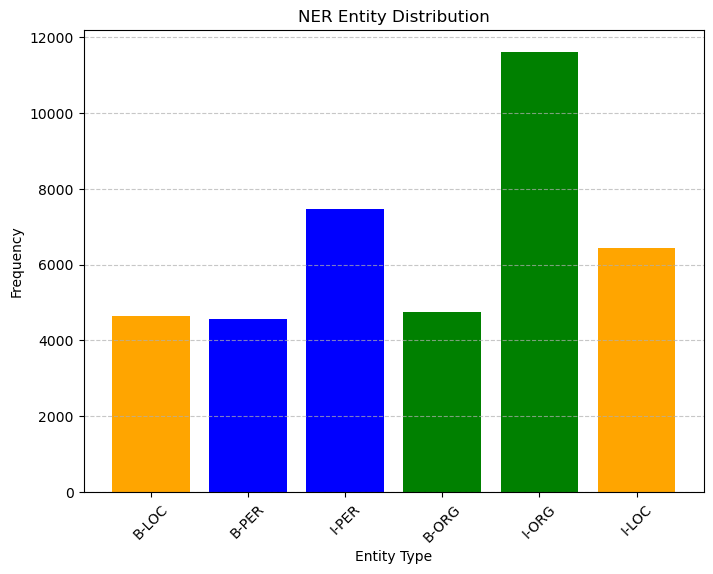

In [9]:
import matplotlib.pyplot as plt

# prepare data for diagram
entities = list(filtered_counts.keys())
counts = list(filtered_counts.values())

# define colours based on entity types
color_map = {
    "PER": "blue",
    "LOC": "orange",
    "ORG": "green"
}

# assign colors for the bars
colors = [color_map[entity.split("-")[1]] for entity in entities]

# create diagram
plt.figure(figsize=(8, 6))
plt.bar(entities, counts, color=colors)
plt.xlabel("Entity Type")
plt.ylabel("Frequency")
plt.title("NER Entity Distribution")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [16]:
def prepare_dataset(examples):
    # The tokenization step is not needed as input_ids are already present
    return {
        'input_ids': examples['input_ids'],
        'attention_mask': examples['attention_mask'],
        'token_type_ids': examples['token_type_ids'],
        'labels': examples['labels']
    }

tokenized_english = english_dataset.map(prepare_dataset, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [17]:
# Create a data loader:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch]),
        'attention_mask': torch.tensor([item['attention_mask'] for item in batch]),
        'token_type_ids': torch.tensor([item['token_type_ids'] for item in batch]),
        'labels': torch.tensor([item['labels'] for item in batch])
    }

data_loader = DataLoader(tokenized_english, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [18]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_mask = [torch.tensor(item['attention_mask']) for item in batch]
    token_type_ids = [torch.tensor(item['token_type_ids']) for item in batch]
    labels = [torch.tensor(item['labels']) for item in batch]
    
    # Pad sequences to the maximum length in the batch
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    token_type_ids = pad_sequence(token_type_ids, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 for padding in labels
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'labels': labels
    }

data_loader = DataLoader(tokenized_english, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [20]:
!pip install seqeval


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 286.1 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=45d35b5eb331ae75142c1b50c5b7a35de1e7ed794f635da11c5ac3eedfdf0390
  Stored in directory: /storage/homefs/jd14r010/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [21]:
from tqdm import tqdm
from seqeval.metrics import classification_report

model.eval()
all_predictions = []
all_true_labels = []

label_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}

with torch.no_grad():
    for batch in tqdm(data_loader, desc="Evaluating"):
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(model.device)
        
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)
        
        for pred, label, mask in zip(predictions, labels, batch['attention_mask']):
            pred = pred.cpu().numpy()
            label = label.cpu().numpy()
            mask = mask.cpu().numpy()
            
            true_label = [label_map.get(l.item(), 'O') for l, m in zip(label, mask) if m != 0]
            pred_label = [label_map.get(p.item(), 'O') for p, m in zip(pred, mask) if m != 0]
            
            # Ensure both lists have the same length
            min_len = min(len(true_label), len(pred_label))
            true_label = true_label[:min_len]
            pred_label = pred_label[:min_len]
            
            all_predictions.append(pred_label)
            all_true_labels.append(true_label)

# Print the classification report
print(classification_report(all_true_labels, all_predictions))

Evaluating: 100%|██████████| 625/625 [01:08<00:00,  9.11it/s]


              precision    recall  f1-score   support

         LOC       0.22      0.25      0.24      5237
         ORG       0.22      0.21      0.22      5988
         PER       0.23      0.23      0.23      5209

   micro avg       0.23      0.23      0.23     16434
   macro avg       0.23      0.23      0.23     16434
weighted avg       0.23      0.23      0.23     16434

